# Vehicle detection and tracking

The goals / steps of this project are the following:
* Extract HOG and color features of images in training set
* Train SVM classifier with HOG and color features
* Use slide window search to detect vehicles
* Generate video which detect and track vehicles

In [209]:
# Use logger to show info and debug
import logging

logger = logging.getLogger()
logger.setLevel(logging.INFO) #logging.INFO logging.DEBUG
if logger.handlers == []:
    ch = logging.StreamHandler()
    logger.addHandler(ch)

## Load data

In [113]:
import glob
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import os
import pickle
import time

def load_image(path, scale=255):
    files = glob.glob(path)
    logger.debug('{} {}'.format(path, np.shape(files)))
    images = [mpimg.imread(x) * scale for x in files] # mpimg read png as 0-1 => scale them up to 0-255
    return images

# Load test images
test_images = np.array(load_image("test_images/*.jpg", scale=1))
logger.info('test_images {}'.format(np.shape(test_images)))

# Load images for training and validation
if "non_vehicle.p" in os.listdir(".") and "vehicle.p" in os.listdir("."):
    logger.info('Use pickle file to load data')
else:
    logger.info('Load data from raw images')
    start = time.time()

    # Load non-vehicle images
    non_vehicle_images = np.array(load_image("non-vehicles/non-vehicles/Extras/*.png"))
    non_vehicle_images = np.append(non_vehicle_images, load_image("non-vehicles/non-vehicles/GTI/*.png"), axis=0)
    logger.info('non_vehicle_images {}'.format(np.shape(non_vehicle_images)))

    # Load vehicle images
    vehicle_images = np.array(load_image("vehicles/vehicles/GTI_Far/*.png"))
    vehicle_images = np.append(vehicle_images, load_image("vehicles/vehicles/GTI_Left/*.png"), axis=0)
    vehicle_images = np.append(vehicle_images, load_image("vehicles/vehicles/GTI_MiddleClose/*.png"), axis=0)
    vehicle_images = np.append(vehicle_images, load_image("vehicles/vehicles/GTI_Right/*.png"), axis=0)
    vehicle_images = np.append(vehicle_images, load_image("vehicles/vehicles/KITTI_extracted/*.png"), axis=0)
    logger.info('vehicle_images {}'.format(np.shape(vehicle_images)))

    end = time.time()
    logger.info('Spend {:.1f} seconds to load all vehicle and non-vehicle images'.format(end - start))

test_images/*.jpg (6,)
Error closing: 'NoneType' object has no attribute 'close'
Error closing: 'NoneType' object has no attribute 'close'
Error closing: 'NoneType' object has no attribute 'close'
Error closing: 'NoneType' object has no attribute 'close'
Error closing: 'NoneType' object has no attribute 'close'
Error closing: 'NoneType' object has no attribute 'close'
test_images (6, 720, 1280, 3)
Use pickle file to load data


In [114]:
# Use pickle to retrieve training data faster in the next run
if "non_vehicle.p" not in os.listdir("."):
    pickle.dump(non_vehicle_images, open("non_vehicle.p", "wb"))

if "vehicle.p" not in os.listdir("."):
    pickle.dump(vehicle_images, open("vehicle.p", "wb"))
    
start = time.time()

non_vehicle_images = pickle.load(open("non_vehicle.p", "rb"))
logger.info('non_vehicle_images {}'.format(np.shape(non_vehicle_images)))
vehicle_images = pickle.load(open("vehicle.p", "rb"))
logger.info('vehicle_images {}'.format(np.shape(vehicle_images)))

end = time.time()
logger.info('Pickle only spends {:.1f} seconds to load all vehicle and non-vehicle images'.format(end - start))

non_vehicle_images (8968, 64, 64, 3)
vehicle_images (8792, 64, 64, 3)
Pickle only spends 2.8 seconds to load all vehicle and non-vehicle images


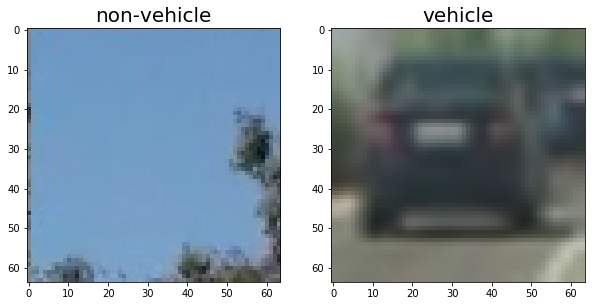

In [115]:
# Show one vehicle example and one non-vehicle example
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
ax1.imshow(non_vehicle_images[0] / 255)
ax1.set_title('non-vehicle', fontsize=20)
ax2.imshow(vehicle_images[0] / 255)
ax2.set_title('vehicle', fontsize=20)
plt.show()

## Extract HOG feature

C:\Users\I054267\AppData\Local\Continuum\miniconda3\envs\carnd-term1_new_tf\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


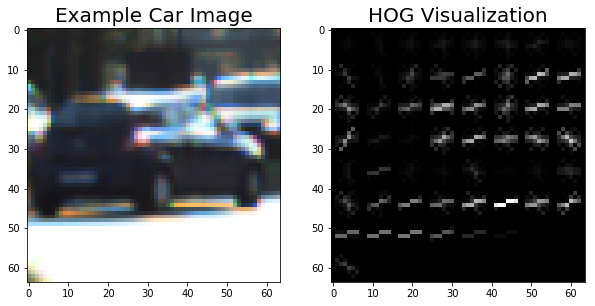

HOG features: shape=(7, 7, 2, 2, 9), max=0.990, min=0.000


In [116]:
from skimage.feature import hog
import cv2

# Define a function to return HOG features and visualization
def get_hog_features(img, orient=9, pix_per_cell=8, cell_per_block=2, vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=True, feature_vector=False)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       visualise=False, feature_vector=feature_vec)
        return features

# Generate a random index to look at a car image
ind = np.random.randint(0, len(vehicle_images))

# Read in the image
image = vehicle_images[ind]
feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)

# Define HOG parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2

# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(feature_image[:,:,0], orient, 
                                       pix_per_cell, cell_per_block, 
                                       vis=True, feature_vec=False)

# Plot the examples
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
ax1.imshow(image / 255, cmap='gray')
ax1.set_title('Example Car Image', fontsize=20)
ax2.imshow(hog_image / 255, cmap='gray')
ax2.set_title('HOG Visualization', fontsize=20)
plt.show()

# The HOG visualization is not actually the feature vector, which contains 7x7x2x2x9 = 1764 features, 
# but rather, a representation that shows the dominant gradient direction within each cell(so it is 8x8x9)
# with brightness corresponding to the strength of gradients in that cell
logger.info('HOG features: shape={}, max={:.3f}, min={:.3f}'.format(np.shape(features), np.max(features), np.min(features)))

## Extract color spatial features

feature_vec: shape=(768,), max=255.000, min=19.750


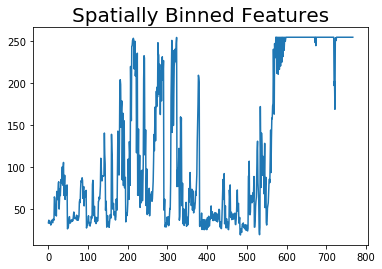

In [157]:
# Define a function to compute color histogram features  
# Pass the color_space flag as 3-letter all caps string
# like 'HSV' or 'LUV' etc.
def bin_spatial(img, color_space='RGB', size=(16, 16)):
    # Convert image to new color space (if specified)
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)             
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(feature_image, size).ravel() 
    # Return the feature vector
    return features
    
feature_vec = bin_spatial(image, color_space='RGB', size=(16, 16))

# Plot features
logger.info('feature_vec: shape={}, max={:.3f}, min={:.3f}'.format(np.shape(feature_vec), np.max(feature_vec), np.min(feature_vec)))
plt.plot(feature_vec)
plt.title('Spatially Binned Features', fontsize=20)
plt.show()

## Extract color histogram features

histogram feature vector: shape=(96,), max=1073.000, min=0.000


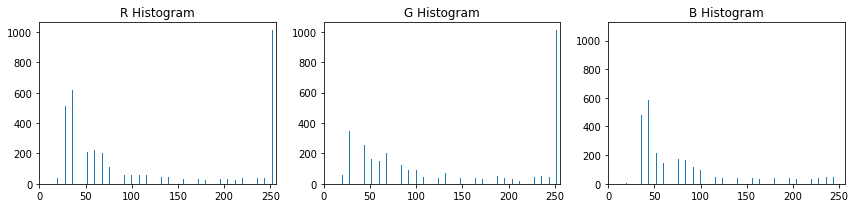

In [118]:
# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256), only_feature=True):
    # Compute the histogram of the RGB channels separately
    rhist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    ghist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    bhist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Generating bin centers
    bin_edges = rhist[1]
    bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((rhist[0], ghist[0], bhist[0]))
    # Return the individual histograms, bin_centers and feature vector
    if only_feature:
        return hist_features
    else:
        return rhist, ghist, bhist, bin_centers, hist_features


# define parameters for color_hist function
bins_upper_bound = 256
nbins = 32

rh, gh, bh, bincen, feature_vec = color_hist(image, nbins=nbins, bins_range=(0, bins_upper_bound), only_feature=False)

# Plot a figure with all three bar charts
if rh is not None:
    logger.info('histogram feature vector: shape={}, max={:.3f}, min={:.3f}'.
                format(np.shape(feature_vec), np.max(feature_vec), np.min(feature_vec)))
    fig = plt.figure(figsize=(12,3))
    plt.subplot(131)
    plt.bar(bincen, rh[0])
    plt.xlim(0, bins_upper_bound)
    plt.title('R Histogram')
    plt.subplot(132)
    plt.bar(bincen, gh[0])
    plt.xlim(0, bins_upper_bound)
    plt.title('G Histogram')
    plt.subplot(133)
    plt.bar(bincen, bh[0])
    plt.xlim(0, bins_upper_bound)
    plt.title('B Histogram')
    fig.tight_layout()
    plt.show()
else:
    print('Your function is returning None for at least one variable...')

## Combine and normalize HOG features, color spatial features, and color histogram features

C:\Users\I054267\AppData\Local\Continuum\miniconda3\envs\carnd-term1_new_tf\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)

hog_features: shape=(1764,), max=0.519, min=0.000
spatial_features: shape=(768,), max=183.250, min=36.750
hist_features: shape=(96,), max=523.000, min=0.000
features: shape=(1, 2628), max=523.000, min=0.000


hog_features: shape=(1764,), max=0.463, min=0.000
spatial_features: shape=(768,), max=185.250, min=34.250
hist_features: shape=(96,), max=581.000, min=0.000
features: shape=(2, 2628), max=581.000, min=0.000


hog_features: shape=(1764,), max=0.495, min=0.000
spatial_features: shape=(768,), max=179.250, min=34.500
hist_features: shape=(96,), max=606.000, min=0.000
features: shape=(3, 2628), max=606.000, min=0.000


total features: shape=(8792, 2628), max=3114.000, min=0.000


hog_features: sha

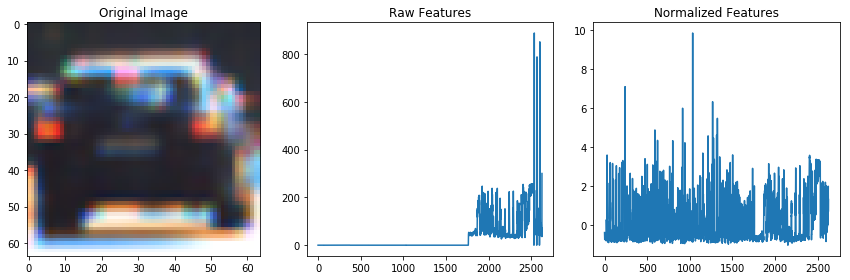

In [205]:
from sklearn.preprocessing import StandardScaler

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(image_list, orient=9, pix_per_cell=8, cell_per_block=2,
                     cspace='RGB', spatial_size=(16, 16),
                     hist_bins=32, hist_range=(0, 256)):
    features = []
    
    for idx, img in enumerate(image_list):        
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
        else: 
            feature_image = np.copy(img)      
        
        if cspace == 'RGB':
            hog_image_ch = cv2.cvtColor(feature_image, cv2.COLOR_RGB2GRAY)
        else:
            hog_image_ch = feature_image[:,:,0]
        
        hog_features = get_hog_features(hog_image_ch, orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block)
        spatial_features = bin_spatial(feature_image, color_space=cspace, size=spatial_size)
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        features.append(np.concatenate((hog_features, spatial_features, hist_features)))
                
        if idx < 3:
            logger.debug('')
            logger.debug('hog_features: shape={}, max={:.3f}, min={:.3f}'.
                         format(np.shape(hog_features), np.max(hog_features), np.min(hog_features)))
            logger.debug('spatial_features: shape={}, max={:.3f}, min={:.3f}'.
                         format(np.shape(spatial_features), np.max(spatial_features), np.min(spatial_features)))
            logger.debug('hist_features: shape={}, max={:.3f}, min={:.3f}'.
                         format(np.shape(hist_features), np.max(hist_features), np.min(hist_features)))
            logger.debug('features: shape={}, max={:.3f}, min={:.3f}'.
                         format(np.shape(features), np.max(features), np.min(features)))
            logger.debug('')
    
    logger.info('')
    logger.info('total features: shape={}, max={:.3f}, min={:.3f}'.
                 format(np.shape(features), np.max(features), np.min(features)))
    logger.info('')
    
    return features

# Extract features for all vehicle images and non-vehicle images        
vehicle_features = extract_features(vehicle_images)
non_vehicle_features = extract_features(non_vehicle_images)

# Plot one example of raw features and normalized features
if len(vehicle_features) > 0:
    # Create an array stack of feature vectors
    X = np.vstack((vehicle_features, non_vehicle_features)).astype(np.float64) 
    logger.info('X: shape={}, max={:.3f}, min={:.3f}'.
                 format(np.shape(X), np.max(X), np.min(X)))
    
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)
    logger.info('scaled_X: shape={}, max={:.3f}, min={:.3f}'.
                 format(np.shape(scaled_X), np.max(scaled_X), np.min(scaled_X)))
    car_ind = np.random.randint(0, len(vehicle_features))
    logger.info('car_ind = {}'.format(car_ind))
    
    # Plot an example of raw and scaled features
    fig = plt.figure(figsize=(12,4))
    plt.subplot(131)
    plt.imshow(vehicle_images[car_ind] / 255)
    plt.title('Original Image')
    plt.subplot(132)
    plt.plot(X[car_ind])
    plt.title('Raw Features')
    plt.subplot(133)
    plt.plot(scaled_X[car_ind])
    plt.title('Normalized Features')
    fig.tight_layout()
    plt.show()
else: 
    print('Your function only returns empty feature vectors...')


## Train classifier SVM with extracted features

In [206]:
from sklearn.cross_validation import train_test_split
from sklearn.svm import LinearSVC

# Define the labels vector
y = np.hstack((np.ones(len(vehicle_features)), np.zeros(len(non_vehicle_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

logger.info('')
logger.info('Feature vector length: {}'.format(len(X_train[0])))
logger.info('Train set size: {}'.format(len(X_train)))
logger.info('Test set size: {}'.format(len(X_test)))
logger.info('')

# Use a linear SVC 
svc = LinearSVC()

# Check the training time for the SVC
start =time.time()
svc.fit(X_train, y_train)
end= time.time()
logger.info('{} Seconds to train SVC...'.format(round(end-start, 2)))

# Check the score of the SVC
logger.info('Test Accuracy of SVC = {}'.format(round(svc.score(X_test, y_test), 4)))

# Check the prediction time for a single sample
start=time.time()
n_predict = 10
logger.info('My SVC predicts:')
logger.info(svc.predict(X_test[0:n_predict]))
logger.info('For these {} labels:'.format(n_predict))
logger.info(y_test[0:n_predict])
end = time.time()
logger.info('{} Seconds to predict {} labels with SVC'.format(round(end-start, 5), n_predict))


Feature vector length: 2628
Train set size: 14208
Test set size: 3552

7.86 Seconds to train SVC...
Test Accuracy of SVC = 0.984
My SVC predicts:
[ 0.  1.  1.  1.  0.  1.  0.  0.  0.  1.]
For these 10 labels:
[ 0.  1.  1.  1.  0.  1.  0.  0.  0.  1.]
0.016 Seconds to predict 10 labels with SVC


## Sliding window to search vehicles

In [238]:
def find_car_single_image(img, svc, X_scaler, scale=1, orient=9, color_space="RGB", feature_vec=False, 
                          ystart=400, ystop=680, xstart=600, xstop=1280, 
                          pix_per_cell=8, cell_per_block=2, spatial_size=(16,16), 
                          hist_bins=32, resize_size=(64,64), cells_per_step=2):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)
    
    bbox_list = []
    
    img_tosearch = img[ystart:ystop,xstart:xstop,:]
    
    if color_space != 'RGB':
        if color_space == 'HSV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    else:
        ctrans_tosearch = np.copy(img_tosearch)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    
    if color_space == 'RGB':
        ch0 = cv2.cvtColor(ctrans_tosearch, cv2.COLOR_RGB2GRAY)
    else:
        ch0 = ctrans_tosearch[:,:,0]
    
    # Define blocks and steps as above
    nxblocks = (ch0.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch0.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 8 * pix_per_cell
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog = get_hog_features(ch0, orient, pix_per_cell, cell_per_block, feature_vec=feature_vec)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_features = hog[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], resize_size)
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)
            
            # Scale features and make a prediction
            test_features = X_scaler.transform(np.concatenate((hog_features, spatial_features, hist_features)).reshape(1, -1))     
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                #logger.debug('xbox_left {}'.format(xbox_left))
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left+xstart, ytop_draw+ystart),
                              (xbox_left+win_draw+xstart,ytop_draw+win_draw+ystart),(0,255,0),5) 
                bbox_list.append(((xbox_left+xstart, ytop_draw+ystart),
                              (xbox_left+win_draw+xstart,ytop_draw+win_draw+ystart)))
                
    return draw_img, bbox_list

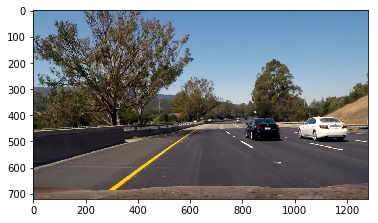

In [259]:
test_image = test_images[5]

plt.imshow(test_image)
plt.show()

C:\Users\I054267\AppData\Local\Continuum\miniconda3\envs\carnd-term1_new_tf\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


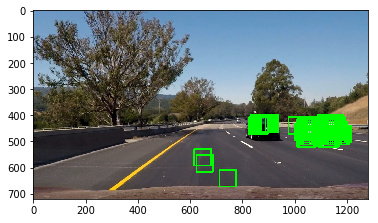

In [260]:
draw_img, _ = find_car_single_image(test_image, svc, X_scaler, pix_per_cell=8, cells_per_step=1)
plt.imshow(draw_img)
plt.show()

C:\Users\I054267\AppData\Local\Continuum\miniconda3\envs\carnd-term1_new_tf\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


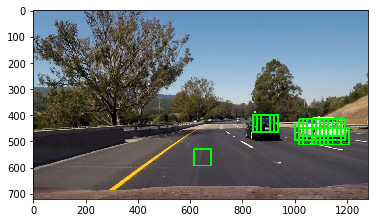

In [261]:
draw_img, _ = find_car_single_image(test_image, svc, X_scaler, pix_per_cell=8, cells_per_step=2)
plt.imshow(draw_img)
plt.show()

C:\Users\I054267\AppData\Local\Continuum\miniconda3\envs\carnd-term1_new_tf\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


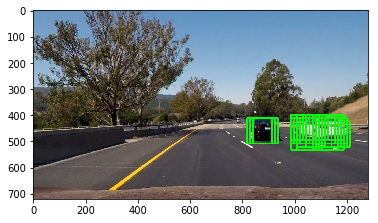

In [262]:
draw_img, _ = find_car_single_image(test_image, svc, X_scaler, pix_per_cell=12, cells_per_step=1)
plt.imshow(draw_img)
plt.show()

C:\Users\I054267\AppData\Local\Continuum\miniconda3\envs\carnd-term1_new_tf\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


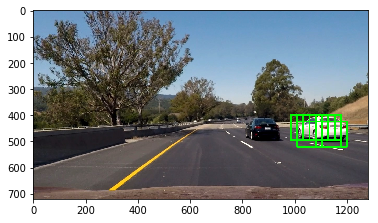

In [263]:
draw_img, _ = find_car_single_image(test_image, svc, X_scaler, pix_per_cell=12, cells_per_step=2)
plt.imshow(draw_img)
plt.show()

C:\Users\I054267\AppData\Local\Continuum\miniconda3\envs\carnd-term1_new_tf\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


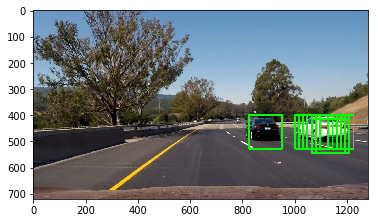

In [264]:
draw_img, _ = find_car_single_image(test_image, svc, X_scaler, pix_per_cell=16, cells_per_step=1)
plt.imshow(draw_img)
plt.show()

C:\Users\I054267\AppData\Local\Continuum\miniconda3\envs\carnd-term1_new_tf\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


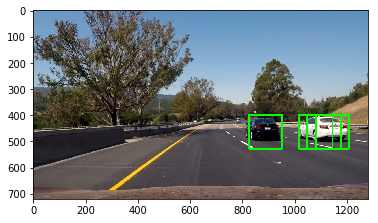

In [265]:
draw_img, _ = find_car_single_image(test_image, svc, X_scaler, pix_per_cell=16, cells_per_step=2)
plt.imshow(draw_img)
plt.show()

## Use heatmap to draw bound box to track vehicle

C:\Users\I054267\AppData\Local\Continuum\miniconda3\envs\carnd-term1_new_tf\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


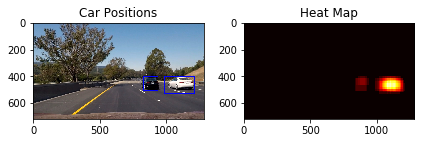

In [276]:
from scipy.ndimage.measurements import label

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

# Generate box_list
box_list = []
_, box_list = find_car_single_image(test_image, svc, X_scaler, pix_per_cell=8, cells_per_step=2)
box_list.extend(find_car_single_image(test_image, svc, X_scaler, pix_per_cell=12, cells_per_step=1)[1])

# Add heat to each box in box list
heat = np.zeros_like(test_image[:,:,0]).astype(np.float)
heat = add_heat(heat,box_list)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,1)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(test_image), labels)

fig = plt.figure()
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()
plt.show()